In [1]:
import gym
import time
import matplotlib.pyplot as plt
from pyswip import Prolog
from project_utils import define_reward, process_state, perform_action, show_match


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                  @###.......                                   
                                  #..#.#.#..#                                   
                                  #........#.                                   
                                  #..#....#..                                   
                           

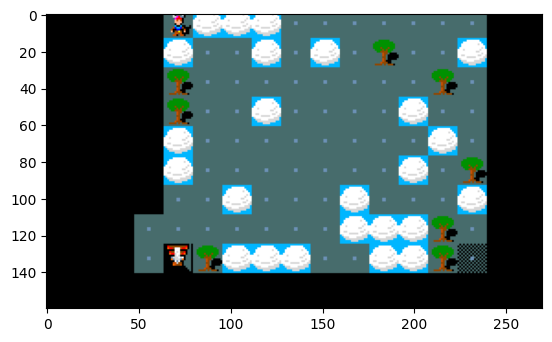

In [2]:

env = gym.make('MiniHack-HideNSeek-Mapped-v0', #VERSIONE MAPPATA PER ORA
              observation_keys=('screen_descriptions','message','pixel','blstats')
               #,seeds = ([17420116293123777999, 3708623693520527574])
              )
obs =  env.reset()
env.render()
plt.imshow(obs['pixel'][115:275, 480:750])
#ALBERI = CANCELLETTO VERDE
#NUVOLE = CANCELLETTO GRIGIO



In [3]:
'''
    'north' =      0
     'east' =      1
     'south' =     2
     'west' =      3
     'northeast' = 4
     'southeast' = 5
     'southwest' = 6
     'northwest' = 7

TO PLAY
'''
'''
for i in range (50):
    print("enter command")
    action_id = int(input())
    env.step(action_id)
    env.render()
    plt.imshow(obs['pixel'][115:275, 480:750])
    for i in range(21):
        for j in range(79):
            if not (obs['screen_descriptions'][i][j] == 0).all(): #.all() returns TRUE if all the items are true
                obj = bytes(obs['screen_descriptions'][i][j]).decode('utf-8').rstrip('\x00')
                plt.imshow(obs['pixel'][115:275, 480:750])
'''


'\nfor i in range (50):\n    print("enter command")\n    action_id = int(input())\n    env.step(action_id)\n    env.render()\n    plt.imshow(obs[\'pixel\'][115:275, 480:750])\n    for i in range(21):\n        for j in range(79):\n            if not (obs[\'screen_descriptions\'][i][j] == 0).all(): #.all() returns TRUE if all the items are true\n                obj = bytes(obs[\'screen_descriptions\'][i][j]).decode(\'utf-8\').rstrip(\'\x00\')\n                plt.imshow(obs[\'pixel\'][115:275, 480:750])\n'

Episode 4 - 8 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
After 5 episodes, mean return is 0.8
The rewards of the episodes are: [1.0, 0.0, 1.0, 1.0, 1.0]


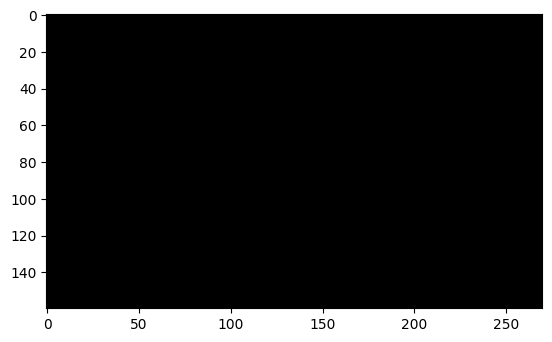

In [4]:
NUM_EPISODES = 5
MAX_STEPS = 25
PATH = 'project_kb.pl'
MONSTER = ['giant', 'ettin', 'titan', 'minotaur', 'naga', 'lich', 'ogre', 'dragon', 'troll', 'Olog-hai'] #possible monsters in this environment
rewards = []
KB = Prolog()
KB.consult(PATH)


for episode in range(NUM_EPISODES):
    # count the number of steps of the current episode
    steps = 0
    # store the cumulative reward
    reward = 0.0
    # collect obs['pixel'] to visualize
    ep_states = []

    obs = env.reset()
    ep_states.append(obs['pixel'])
    done = False

    # Main loop
    while not done and steps < MAX_STEPS:
        # Get the observation from the env and assert the facts in the kb 
        process_state(obs, KB, MONSTER, steps)
       
        # print(f'> Current player position: {player_pos}')
        # Query Prolog
        # Run the inference and get the action to perform
        # Get the first answer from Prolog -> the top-priority action
        try:
            action = list(KB.query('action(X)'))[0]
            action = action['X']
            time.sleep(0.5)
        except Exception as e:
            action = None

        # Perform the action in the environment
        if action:
            obs, reward, done, info = perform_action(action, env)
            # print(f'>> Current action from Prolog: {action}')
            ep_states.append(obs['pixel'])
            #env.render()
        else:
            print("ERROR: impossible to perform any action. Please check assertions and definitions in KB.")
            break

        steps += 1

    # Display game with interface
    show_match(ep_states)
    # Print information about the ended episode
    print(f'Episode {episode} - {steps} steps')
    
    try:
        print(f'End status: {info["end_status"].name}')
            
    except NameError as e1:
        print(f'No end status info available')

    if reward < 1.0:
        seeds = env.get_seeds()
        print({seeds})
        try:
            f = open("unsolved_maps/seeds.txt", "a")
            f.write(str(seeds[0]))
            f.write(' ')
            f.write(str(seeds[1]))
            f.write('\n')
            f.close()
            
        except FileNotFoundError as e:
            print(f'File not found')
    
    print(f'Final reward: {reward}')
    time.sleep(0.75)
    rewards.append(reward)
    obs = env.reset()


print(f'After {NUM_EPISODES} episodes, mean return is {sum(rewards)/NUM_EPISODES}')
print("The rewards of the episodes are:", rewards)